Five Classes Vertical Translation. Bidimensional.
Stream mode with pool size = 300



METHOD: Static lp as classifier
Execution time:  11.368027508927403
Average micro-F1: 0.4067
Average Accuracy:  41.3248
Standard Deviation:  10.1158830045
Variance:  102.33108896


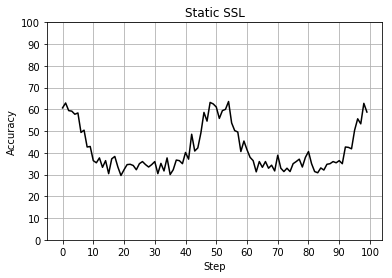

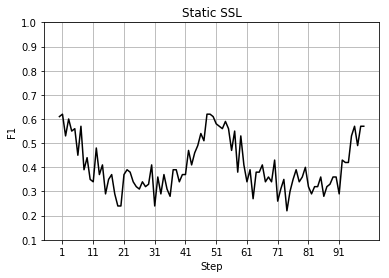




METHOD: Sliding lp as classifier


C:\Users\raul\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Execution time:  10.800414103540106
Average micro-F1: 0.3796999999999999
Average Accuracy:  38.1176
Standard Deviation:  7.88749074421
Variance:  62.21251024


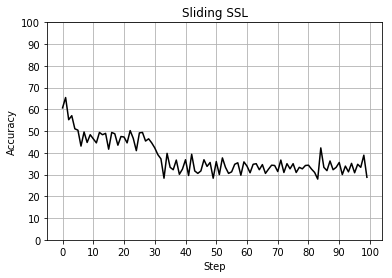

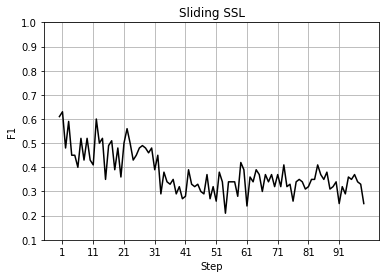




METHOD: Incremental lp as classifier


In [ ]:
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[3])

import setup
from methods import runExperiments
from methods import static_labelpropagation
from methods import amanda_dynamic
from methods import amanda_fixed
from methods import incremental_LN
from methods import deslizante_LN
from methods import scargc_1NN


class Experiment():
     def __init__(self, method, K=None, excludingPercentage=None, densityFunction=None, clfName=None):
        self.method = method
        self.clfName = clfName
        self.densityFunction=densityFunction
        self.excludingPercentage = excludingPercentage
        self.K_variation = K


def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    # SETTINGS
    sslClassifier = 'lp' # lp = label propagation, rf = random forests, cl = cluster and label, knn = k-nn, svm = svm
    steps = 100
    poolSize = 300
    isBatchMode = False # False = Stream
    isBinaryClassification = False
    isImbalanced = False
    externalResults = {}
    
    # Load dataset
    dataValues, dataLabels, description = setup.load5CVT(path, sep)
    
    # Only 5% of initial labeled data - Extreme verification latency scenario
    labeledData = 50 #int(0.05*len(dataLabels))

    # Static SSL
    experiments[0] = Experiment(static_labelpropagation, 6, clfName=sslClassifier)
    
    # Sliding SSL
    experiments[1] = Experiment(deslizante_LN, 6, clfName=sslClassifier)
    
    # Incremental SSL
    experiments[2] = Experiment(incremental_LN, 6, clfName=sslClassifier)
    
    # Proposed Method 1 (AMANDA - Fixed core extraction percentage)
    experiments[3] = Experiment(amanda_fixed, 6, 0.7, "kde", sslClassifier)

    # Proposed method 2 (AMANDA - Dynamic core extraction percentage)
    experiments[4] = Experiment(amanda_dynamic, 6, None, "kde", sslClassifier)

    # SCARGC 1NN (Python version)
    experiments[5] = Experiment(scargc_1NN, 5) 
    
    # Run experiments
    runExperiments.run(dataValues, dataLabels, description, isBinaryClassification, isImbalanced, 
                       experiments, steps, labeledData, isBatchMode, poolSize, externalResults)
    

if __name__ == "__main__":
    main()